<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Classification-of-text-documents-using-sparse-features" data-toc-modified-id="Classification-of-text-documents-using-sparse-features-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Classification of text documents using sparse features</a></span></li></ul></div>

__File Info:__

Date: 20181031

Author: Stephanie Langeland 

File Name: 09_text_classification_sklearn.ipynb

Version: 01

Previous Version/File: None

Dependencies: None

Purpose: Classification of text documents using sparse features using scikit-learn.

Input File(s): None

Output File(s): None

Required by: 
- A beginner's guide to Python.
- Tutorial: http://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py

Status: Complete

Machine: Dell Latitude - Windows 10

Python Version: Python 3

# Classification of text documents using sparse features

This is an example showing how scikit-learn can be used to classify documents by topics using a bag-of-words approach. This example uses a scipy.sparse matrix to store the features and demonstrates various classifiers that can efficiently handle sparse matrices.

The dataset used in this example is the 20 newsgroups dataset. It will be automatically downloaded, then cached.

The bar plot indicates the accuracy, training time (normalized) and test time (normalized) of each classifier.

In [1]:
import logging ## https://docs.python.org/2/howto/logging.html
import numpy as np
from optparse import OptionParser
    ## https://docs.python.org/2/library/optparse.html#module-optparse
    ## http://www.alexonlinux.com/pythons-optparse-for-human-beings
import sys ## https://docs.python.org/2/library/sys.html
from time import time ## This module provides various time-related functions.
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups ## returns a list of the raw texts that can be fed to text feature extractors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

Text data we will be working with: http://qwone.com/~jason/20Newsgroups/

Display progress logs:

In [2]:
logging.basicConfig( ## used to change the configuration defaults, which results in output (written to /tmp/myapp.log)
    level = logging.INFO, ## Report events that occur during normal operation of a program (e.g. for status monitoring or fault investigation)
    format = "%(asctime)s %(levelname)s %(message)s" ## date & time of event followed levelname (severity) then message (event description, including variable data) 
)

Parse command line arguments:

In [3]:
op = OptionParser()


op.add_option( ## add_option() for every command line option that we would like our program to support
    "--report", ## create a report
    action = "store_true", ## store a true value
    dest = "print_report", ## dest specifies the name of the variable that will hold True (true in this case via "store_true") or False value once optparse runs
    help = "Print a detailed classification report." ## short help string that would tell user what this particular command line option does
)


op.add_option(
    "--chi2_select",
    action = "store", ## take the next argument (or the remainder of the current argument), ensure that it is of the correct type, and store it to your chosen destination
    type = "int", ## integer type
    dest = "select_chi2",
    help = "Select some number of features using a chi-squared test."
)


op.add_option(
    "--confusion_mtrix",
    action = "store_true",
    dest = "print_cm",
    help = "Print the confusion matrix."
)


op.add_option(
    "--top10",
    action = "store_true",
    dest = "print_top10",
    help = "Print ten most discriminative terms per class\nfor every classifer."
)


op.add_option(
    "--all_categories",
    action = "store_true",
    dest = "all_categories",
    help = "Whether to use all categories or not."
)


op.add_option(
    "--use_hashing", ## hashing = Convert a collection of text documents to a matrix of token occurrences
    action = "store_true",
    help = "Use a hashing vectorizer."
)


op.add_option(
    "--n_features",
    action = "store",
    type = int,
    default = 2 ** 16,
    help = "n_features when using the hashing vectorizer."
)


op.add_option(
    "--filtered",
    action = "store_true",
    help = "Remove newsgroup information that is easily overfit:\nheaders, signatures, and quoting."
)


def is_interactive(): ## define a new function
    return not hasattr( ## hasattr() method returns true if an object has the given named attribute and false if it does not
        sys.modules["__main__"],
        "__file__"
    )


## work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:] ## sys.argv = arguments vector; sys.argv[1:] starting at 1 - inf

(opts, args) = op.parse_args(argv) ## write user-friendly command-line interfaces. The program defines what arguments it requires, and argparse will figure out how to parse those out of sys.argv. The argparse module also automatically generates help and usage messages and issues errors when users give the program invalid arguments

if len(args) > 0:
    op.error("this script takes no arguments.") ## if the length of args >0, then produce the above error msg then exit via next line below
    sys.exit(1) ## means there was some issue / error / problem and that is why the program is exiting as opposed to "exit(0) = a clean exit without any errors / problems"

print(__doc__) ## print documentation for the object we just created 

op.print_help() ## prints standard output below of the stuff we previous created

print()

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report.
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared
                        test.
  --confusion_mtrix     Print the confusion matrix.
  --top10               Print ten most discriminative terms per class for
                        every classifer.
  --all_categories      Whether to use all categories or not.
  --use_hashing         Use a hashing vectorizer.
  --n_features=N_FEATURES
                        n_features when using the hashing vectorizer.
  --filtered            Remove newsgroup information that is easily overfit:
                        headers, signatures, and quoting.



Load some categories from the training set:

In [4]:
## what is opts doing?
print(opts.all_categories)

None


In [5]:
if opts.all_categories:
    categories = None
else:
    categories = [ # the following was selected from a list of the 20 newsgroups, partitioned according to subject matter
        "alt.atheism",
        "talk.religion.misc",
        "comp.graphics",
        "sci.space"
    ]

In [6]:
print(opts.filtered)

None


In [7]:
if opts.filtered:
    remove = ("headers", "footers", "quotes")
else:
    remove = () ## remove() method removes the element which is passed as an argument so in thise case, its the headers, footers, and quotes
    
print("Loading 20 newsgroups dataset for categories:")
    
print(categories if categories else "all")

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']


Training and Testing Data:

In [8]:
data_train = fetch_20newsgroups(
    subset = "train",
    categories = categories,
    shuffle = True, 
    random_state = 42,
    remove = remove
)


data_test = fetch_20newsgroups(
    subset = "test",
    categories = categories,
    shuffle = True, 
    random_state = 42,
    remove = remove
)


print("data loaded")

data loaded


The order of labels in `target_names` can be different from `categories`:

In [9]:
print(data_train.target) ## this will become the Y var in training
print(data_test.target) ## this will become the Y var in testing

[1 3 2 ... 1 0 1]
[2 1 1 ... 3 1 1]


In [10]:
print(data_train.target_names)

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


In [11]:
print(categories)

['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']


In [12]:
target_names = data_train.target_names

def size_mb(docs): ## return the megabyte size of an object
    return sum(
        len(
            s.encode("utf-8") ## method encode() returns an encoded version of the string. Default encoding is the current default string encoding. The errors may be given to set a different error handling scheme.
        ) for s in docs 
    ) / 1e6 ## divide by 1,000,000 which is the byte size of a megabyte


data_train_size_mb = size_mb(data_train.data) 

data_test_size_mb = size_mb(data_test.data)

In [13]:
print(data_train_size_mb)

3.979536


In [14]:
print(data_test_size_mb)

2.86749


In [15]:
print(
    "%d documents - %0.3fMB (training set)" %(
        len(data_train.data),
        data_train_size_mb
    )
)


print(
    "%d documents - %0.3fMB (test set)" %(
        len(data_test.data),
        data_test_size_mb
    )
)


print(
    "%d categories" % len(categories)
)



print()

2034 documents - 3.980MB (training set)
1353 documents - 2.867MB (test set)
4 categories



Split into training and testing:

In [16]:
print(opts.n_features)

65536


In [17]:
y_train, y_test = data_train.target, data_test.target

print("Extracting features from the training data using a sparse vectorizer")

t0 = time() ## start time

if opts.use_hashing: ## if n_features = opts.n_features then use hashing, otherwise use the TfidfVextorizer in the "else" part of this code
    vectorizer = HashingVectorizer( ## Converts text documents to a matrix of token occurrences
        stop_words = "english", ## remove english stop words
        alternate_sign = False, ## When True, an alternating sign is added to the features as to approximately conserve the inner product in the hashed space even for small n_features. This approach is similar to sparse random projection.
        n_features = opts.n_features ## The number of features (columns) in the output matrices. Small numbers of features are likely to cause hash collisions, but large numbers will cause larger coefficient dimensions in linear learners.
    ) 
    
    X_train = vectorizer.transform(data_train.data) ## transform the raw text (data_train) using the vectorizer function above
else: ## if not 
    vectorizer = TfidfVectorizer( ## TfidfVectorizer uses a in-memory vocabulary (a python dict) to map the most frequent words to features indices and hence compute a word occurrence frequency (sparse) matrix. The word frequencies are then reweighted using the Inverse Document Frequency (IDF) vector collected feature-wise over the corpus.
        sublinear_tf = True, ## Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf) to make it inverse rather than regular tfm
        max_df = 0.5, ### When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words - specified on the next line). If float, the parameter represents a proportion of documents (here, 0.5 is the prop of docs), integer absolute counts.
        stop_words = "english"
    )
    
    X_train = vectorizer.fit_transform(data_train.data) ## transform the raw text (data_train) using the vectorizer function above - TFIDF in this part of the function


duration = time() - t0 ## how long the above text preprocessing took to run

print(
    "done in %fs at %0.3fMB/s" % (
        duration, 
        data_train_size_mb / duration
    )
)


print(
    "n_samples: %d, n_features: %d" % X_train.shape
)

print()

Extracting features from the training data using a sparse vectorizer
done in 0.826840s at 4.813MB/s
n_samples: 2034, n_features: 33809



In [18]:
X_train

<2034x33809 sparse matrix of type '<class 'numpy.float64'>'
	with 224893 stored elements in Compressed Sparse Row format>

    This is a sparse matrix so `X_train` is a TFIDF matrix.

In [19]:
print("Extracting features from the test data using the same vectorizer")

t0 = time()

X_test = vectorizer.transform(data_test.data) ## use the same vectorizer as used for X_train

duration = time() - t0

print(
    "done in %fs at %0.3fMB/s" % (
        duration, 
        data_test_size_mb / duration
    )
)


print(
    "n_samples: %d, n_features: %d" % X_test.shape
)


print()

Extracting features from the test data using the same vectorizer
done in 0.480714s at 5.965MB/s
n_samples: 1353, n_features: 33809



In [20]:
X_test

<1353x33809 sparse matrix of type '<class 'numpy.float64'>'
	with 142188 stored elements in Compressed Sparse Row format>

Mapping from integer feature name to original token string:

In [21]:
if opts.use_hashing:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names()

    
if opts.select_chi2:
    print(
        "Extracting %d best features by a chi-squared test" % 
        opts.select_chi2
    )
    
    t0 = time() ## start time 
    
    ch2 = SelectKBest( ## Select features according to the k highest scores
        chi2, ## from this object
        k = opts.select_chi2 ## Number of top features to select.
    )
    
    X_train = ch2.fit_transform(
        X_train,
        y_train
    )
    
    X_test = ch2.transform(X_test)
    
    if feature_names: ## keep selected feature names
        feature_names = [
            feature_names[i] for i in ch2.get_support(
                indicies = True
            )
        ]
        
    print(
        "done in %fs" % (time() - t0)
    )
    
    print()

if feature_names:
    feature_names = np.array(feature_names)

def trim(s): ## create trim fn that we'll use later 
    """Trim string to fit terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..." ## character limit per line

Benchmark classifiers:

In [22]:
def benchmark(clf): ## create benchmark fn that we'll use later
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(
        X_train, 
        y_train
    )
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score( ## classification accuracy score
        y_test,
        pred
    )
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("classification report:")
        print(
            metrics.classification_report(
            y_test, 
            pred,
            target_names = target_names
            )
        )

    if opts.print_cm:
        print("confusion matrix:")
        print(
            metrics.confusion_matrix(
                y_test, 
                pred
            )
        )

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (
            RidgeClassifier(
                tol = 1e-2, 
                solver = "sag"
            ), 
            "Ridge Classifier"
        ),
        (
            Perceptron(
                max_iter = 50, 
                tol = 1e-3
            ), 
            "Perceptron"
        ),
        (
            PassiveAggressiveClassifier(
                max_iter = 50, 
                tol = 1e-3
            ),
            "Passive-Aggressive"
        ),
        (
            KNeighborsClassifier(
                n_neighbors = 10
            ), 
            "kNN"
        ),
        (
            RandomForestClassifier(n_estimators = 100), 
            "Random forest"
        )
):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(
        benchmark(
            LinearSVC(
                penalty = penalty, 
                dual = False,
                tol = 1e-3
            )
        )
    )

    # Train SGD model
    results.append(
        benchmark(
            SGDClassifier(
                alpha = 0.0001, 
                max_iter = 50,
                penalty = penalty
            )
        )
    )

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='sag',
        tol=0.01)
train time: 0.327s
test time:  0.003s
accuracy:   0.896
dimensionality: 33809
density: 1.000000


Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=50, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=0.001,
      validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.025s
test time:  0.003s
accuracy:   0.888
dimensionality: 33809
density: 0.240114


Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C

Train SGD (Stochastic Gradient Descent) with Elastic Net penalty:

In [23]:
print('=' * 80)
print("Elastic-Net penalty")
results.append(
    benchmark(
        SGDClassifier(
            alpha = 0.0001, 
            max_iter = 50,
            penalty = "elasticnet"
        )
    )
)

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='elasticnet',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.849s
test time:  0.003s
accuracy:   0.902
dimensionality: 33809
density: 0.187517




Train NearestCentroid without threshold:

In [24]:
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(
    benchmark(
        NearestCentroid()
    )
)

NearestCentroid (aka Rocchio classifier)
________________________________________________________________________________
Training: 
NearestCentroid(metric='euclidean', shrink_threshold=None)
train time: 0.014s
test time:  0.006s
accuracy:   0.855



Train sparse Naive Bayes classifiers:

In [25]:
print('=' * 80)
print("Naive Bayes")
results.append(
    benchmark(
        MultinomialNB(alpha = 0.01)
    )
)
results.append(
    benchmark(
        BernoulliNB(alpha = 0.01)
    )
)
results.append(
    benchmark(
        ComplementNB(alpha = 0.1)
    )
)

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(
    benchmark(
        Pipeline(
            [
                (
                    'feature_selection', 
                    SelectFromModel(
                        LinearSVC(
                            penalty = "l1", 
                            dual = False,
                            tol = 1e-3
                        )
                    )
                ),
                (
                    'classification', 
                    LinearSVC(penalty = "l2")
                )
            ]
        )
    )
)

Naive Bayes
________________________________________________________________________________
Training: 
MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
train time: 0.014s
test time:  0.003s
accuracy:   0.899
dimensionality: 33809
density: 1.000000


________________________________________________________________________________
Training: 
BernoulliNB(alpha=0.01, binarize=0.0, class_prior=None, fit_prior=True)
train time: 0.014s
test time:  0.010s
accuracy:   0.884
dimensionality: 33809
density: 1.000000


________________________________________________________________________________
Training: 
ComplementNB(alpha=0.1, class_prior=None, fit_prior=True, norm=False)
train time: 0.014s
test time:  0.003s
accuracy:   0.911
dimensionality: 33809
density: 1.000000


LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
Pipeline(memory=None,
     steps=[('feature_selection', SelectFromModel(estimator=

Plot:

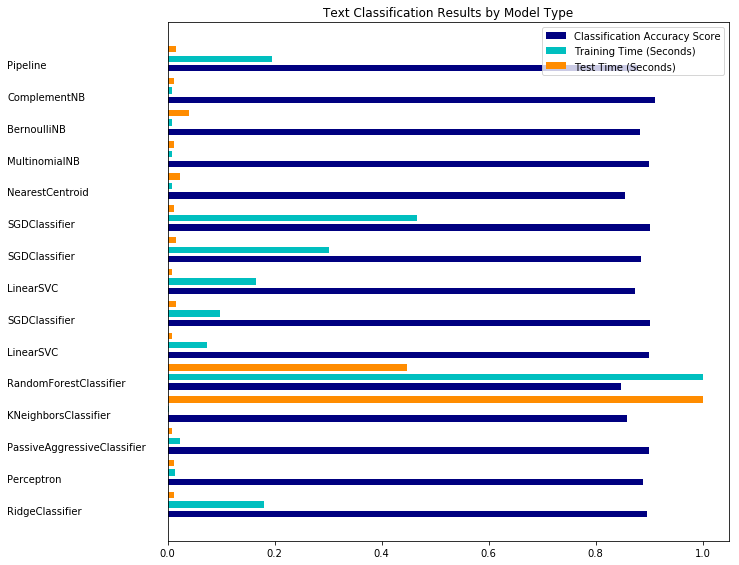

In [26]:
indices = np.arange(
    len(results)
)

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results

training_time = np.array(training_time) / np.max(training_time)

test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize = (12, 8));

plt.title("Text Classification Results by Model Type");

plt.barh(
    indices, 
    score, 
    0.2, 
    label = "Classification Accuracy Score", 
    color = 'navy'
);

plt.barh(
    indices + 0.3, 
    training_time, 
    0.2, 
    label = "Training Time (Seconds)",
    color = 'c'
);

plt.barh(
    indices + 0.6, 
    test_time, 
    0.2, 
    label = "Test Time (Seconds)", 
    color = 'darkorange'
);

plt.yticks(());

plt.legend(loc = 'best');

plt.subplots_adjust(left = 0.25);

plt.subplots_adjust(top = 0.95);

plt.subplots_adjust(bottom = 0.05);

for i, c in zip(indices, clf_names):
    plt.text(
        -0.3, 
        i, 
        c
    )

plt.show();